## Integrating a simple harmonic oscillator and trying to infer the spring constant

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
import scipy.optimize as so
%matplotlib inline
import autograd.numpy as np  # Thinly-wrapped numpy
from autograd import grad  


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
session = tf.get_default_session()
if session is None:
    session = tf.InteractiveSession()

import theano
import theano.tensor as tt

def _to_tensor_type(shape):
    return tt.TensorType(dtype="float64", broadcastable=[False]*len(shape))


class TensorFlowOp(tt.Op):
    """A custom Theano Op uses TensorFlow as the computation engine
    
    Args:
        target (Tensor): The TensorFlow tensor defining the output of
            this operation
        parameters (list(Tensor)): A list of TensorFlow tensors that
            are inputs to this operation
        names (Optional(list)): A list of names for the parameters.
            These are the names that will be used within PyMC3
        feed_dict (Optional(dict)): A "feed_dict" that is provided to
            the TensorFlow session when the operation is executed
        session (Optional): A TensorFlow session that can be used to
            evaluate the operation
    
    """
    def __init__(self, target, parameters, names=None, feed_dict=None, session=None):
        self.parameters = parameters
        self.names = names
        self._feed_dict = dict() if feed_dict is None else feed_dict
        self._session = session
        self.target = target
        
        # Execute the operation once to work out the shapes of the
        # parameters and the target
        in_values, out_value = self.session.run(
            [self.parameters, self.target], feed_dict=self._feed_dict)
        self.shapes = [np.shape(v) for v in in_values]
        self.output_shape = np.shape(out_value)
        
        # Based on this result, work out the shapes that the Theano op
        # will take in and return
        self.itypes = tuple([_to_tensor_type(shape) for shape in self.shapes])
        self.otypes = tuple([_to_tensor_type(self.output_shape)])
        
        # Build another custom op to represent the gradient (see below)
        self._grad_op = _TensorFlowGradOp(self)

    @property
    def session(self):
        """The TensorFlow session associated with this operation"""
        if self._session is None:
            self._session = tf.get_default_session()
        return self._session
    
    def get_feed_dict(self, sample):
        """Get the TensorFlow feed_dict for a given sample
        
        This method will only work when a value for ``names`` was provided
        during instantiation.
        
        sample (dict): The specification of a specific sample in the chain
        
        """
        if self.names is None:
            raise RuntimeError("'names' must be set in order to get the feed_dict")
        return dict(((param, sample[name])
                     for name, param in zip(self.names, self.parameters)),
                    **self._feed_dict)
    
    def infer_shape(self, node, shapes):
        """A required method that returns the shape of the output"""
        return self.output_shape,

    def perform(self, node, inputs, outputs):
        """A required method that actually executes the operation"""
        # To execute the operation using TensorFlow we must map the inputs from
        # Theano to the TensorFlow parameter using a "feed_dict"
        feed_dict = dict(zip(self.parameters, inputs), **self._feed_dict)
        outputs[0][0] = np.array(self.session.run(self.target, feed_dict=feed_dict))

    def grad(self, inputs, gradients):
        """A method that returns Theano op to compute the gradient
        
        In this case, we use another custom op (see the definition below).
        
        """
        op = self._grad_op(*(inputs + gradients))
        # This hack seems to be required for ops with a single input
        if not isinstance(op, (list, tuple)):
            return [op]
        return op

class _TensorFlowGradOp(tt.Op):
    """A custom Theano Op defining the gradient of a TensorFlowOp
    
    Args:
        base_op (TensorFlowOp): The original Op
    
    """
    def __init__(self, base_op):
        self.base_op = base_op
        
        # Build the TensorFlow operation to apply the reverse mode
        # autodiff for this operation
        # The placeholder is used to include the gradient of the
        # output as a seed
        self.dy = tf.placeholder(tf.float64, base_op.output_shape)
        self.grad_target = tf.gradients(base_op.target,
                                        base_op.parameters,
                                        grad_ys=self.dy)

        # This operation will take the original inputs and the gradient
        # seed as input
        types = [_to_tensor_type(shape) for shape in base_op.shapes]
        self.itypes = tuple(types + [_to_tensor_type(base_op.output_shape)])
        self.otypes = tuple(types)
 
    def infer_shape(self, node, shapes):
        return self.base_op.shapes

    def perform(self, node, inputs, outputs):
        feed_dict = dict(zip(self.base_op.parameters, inputs[:-1]),
                         **self.base_op._feed_dict)
        feed_dict[self.dy] = inputs[-1]
        result = self.base_op.session.run(self.grad_target, feed_dict=feed_dict)
        for i, r in enumerate(result):
            outputs[i][0] = np.array(r)

In [4]:
def genData(x, v, npoints, std_noise_x, std_noise_v):
    noise_x = np.random.normal(0, std_noise_x, len(x))
    noise_v = np.random.normal(0, std_noise_v, len(x))
    return noise_x + x, noise_v + v

In [5]:
def ln_likelihood(theta, data, dt_model):
    chi2 = 0
    k, x0, v0, *t_obs = theta
    x_obs, v_obs, sigma_x, sigma_v = data
    x, v = leapfrog(x0, v0, np.array(t_obs), phi_grad, dt, k=k)
    chi2 += -(v - v_obs)**2 / sigma_v**2 - 2*np.log(sigma_v)
    chi2 += -(x - x_obs)**2 / sigma_x**2 - 2*np.log(sigma_x)
    return 0.5*chi2.sum()

In [6]:
np.random.seed(42)

In [7]:
x0_true   = 100.
v0_true   = 100.
k_true    = 10.

dt        = 0.01
max_time  = 5.

nobspoints = 30
std_noise_x = 10.0
std_noise_v = 10.0

plot_xerr = np.zeros(nobspoints) + std_noise_x
plot_yerr = np.zeros(nobspoints) + std_noise_v
t_obs_true = np.random.uniform(0, max_time, nobspoints)
t_obs_true.sort()

#assert nmodelpoints > nobspoints, 'The number of model points must be greater than the number of observed points'

In [8]:
#generate true values and noisify them
x_true, v_true = leapfrog(x0_true, v0_true, t_obs_true, phi_grad, dt, k=k_true)
x_obs, v_obs = genData(x_true, v_true, nobspoints, std_noise_x, std_noise_v)
plt.plot(t_obs_true, v_obs, 'k')
#plt.plot(t_obs_true, x_obs, 'k')
#v_obs += 1000
plt.plot(t_obs_true, v_obs, 'bo')
#plt.plot(t_obs_true, x_obs, 'bo')

NameError: name 'leapfrog' is not defined

In [ ]:
#assert np.allclose(t_true, t_obs), 'Observed times and integrated times are not the same'

In [ ]:
data   = [x_obs, v_obs, std_noise_x, std_noise_v]
p_true = [k_true, x0_true, v0_true, t_obs_true]
k_guess = k_true  + np.random.normal(0, k_true)
x0_guess = x0_true + np.random.normal(0, std_noise_x)
v0_guess = v0_true + np.random.normal(0, std_noise_v)
t0_guess = t_obs_true + np.random.normal(0, 1., len(t_obs_true))
p0     = [k_guess, 
          x0_guess, 
          v0_guess] + (t0_guess).tolist()
args   = (data, dt)

#for plotting purposes
t_compare = np.linspace(0, max_time, 1000)

In [9]:
import tensorflow as tf
from tensorflow.contrib.bayesflow.python.ops.hmc_impl import *

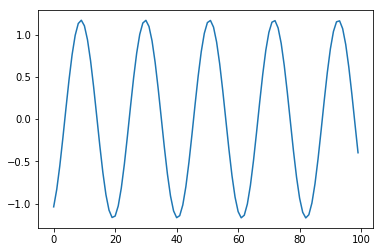

In [10]:
def potential_and_grad(position):
    return tf.reduce_sum(0.5 * tf.square(position)), position
position = tf.placeholder(np.float32)
momentum = tf.placeholder(np.float32)
potential, grad = potential_and_grad(position)
new_position, new_momentum, new_potential, new_grad = leapfrog_integrator(
0.1, 3, position, momentum, potential_and_grad, grad)
sess = tf.Session()
position_val = np.random.randn(10)
momentum_val = np.random.randn(10)
potential_val, grad_val = sess.run([potential, grad],
                                 {position: position_val})
positions = np.zeros([100, 10])
for i in range(100):
    position_val, momentum_val, potential_val, grad_val = sess.run(
  [new_position, new_momentum, new_potential, new_grad],
  {position: position_val, momentum: momentum_val})
    positions[i] = position_val
# Should trace out sinusoidal dynamics.
plt.plot(positions[:, 0])


[ 0.27437139  0.37353125  1.81244159  2.50440931  0.37023968  5.3151989
  0.70818257  3.12555575  1.13702524  1.30462515] [-1.65641594  1.93269563 -4.25727797  5.00440693 -1.92416131  7.2905407
 -2.66117001  5.59066725  3.37198043 -3.61195946]
(10,)


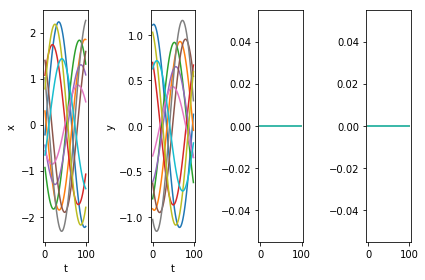

In [40]:
def potential_and_grad(position, k=0.0):
    #function that returns the potential and it's gradient at a given position
    return 0.5 * tf.multiply(k,tf.square(position)), tf.multiply(k,position)

#create placeholders for initial position and momentum to define model
position = tf.placeholder(np.float32)
momentum = tf.placeholder(np.float32)

#define potential
k = tf.placeholder(np.float32)
potential, grad = potential_and_grad(position, k=k)

#define step size of each leap and number of leaps
step_size = 0.01
n_steps = 10
n_shos = 10
#define model, leapfrog_integrator is from hmc tensorflow stuff
new_position, new_momentum, new_potential, new_grad = leapfrog_integrator(
step_size, n_steps, position, momentum, potential_and_grad, grad)

#start session
sess = tf.Session()

#generate initial velocities and momenta
position_val = np.random.randn(n_shos)
momentum_val = np.random.randn(n_shos)
k_val = np.float32(5.0)
#calculate potential and gradient at these random positions 
potential_val, grad_val = sess.run([potential, grad],
                                 {position: position_val, k:k_val})
print(potential_val, grad_val)
#generate arrays to save values from model
nruns = 100
positions = np.zeros([nruns, n_shos])
momenta   = np.zeros([nruns, n_shos])
grad      = np.zeros([nruns, n_shos])
potential = np.zeros([nruns, n_shos])

#run model on random initial positions and momenta

for i in range(nruns):
    position_val, momentum_val, potential_val, grad_val = sess.run(
  [new_position, new_momentum, new_potential, new_grad],
  {position: position_val, momentum: momentum_val, k:k_val})

    #print(position_val.shape)
    positions[i] = position_val
    momenta[i] = momentum_val
    grad[i] = grad_val
    potential[i] = potential_val
# Plot positions and momenta 
fig, ax = plt.subplots(1,4)
ax[0].plot(positions)
ax[0].set_xlabel('t')
ax[0].set_ylabel('x')
ax[1].set_xlabel('t')
ax[1].set_ylabel('y')
ax[1].plot(momenta)
ax[2].plot(grad)
ax[3].plot(potential)
#plt.title('Its working!!')
plt.tight_layout()

print(position_val.shape)
#potential_val, grad_val = sess.run([potential, grad],
#                                 {position: position_val, k:k_val})


In [12]:
np.random.randn(10)

array([-0.07201012,  1.0035329 ,  0.36163603, -0.64511975,  0.36139561,
        1.53803657, -0.03582604,  1.56464366, -2.6197451 ,  0.8219025 ])

In [13]:
def potential_and_grad(position, k=0.0):
    #function that returns the potential and it's gradient at a given position
    return tf.reduce_sum(0.5 * tf.multiply(k,tf.square(position))), tf.multiply(k,position)

#create placeholders for initial position and momentum to define model
position = tf.placeholder(np.float32)
momentum = tf.placeholder(np.float32)

#define potential
k = tf.placeholder(np.float32)
potential, grad = potential_and_grad(position, k=k)

#define step size of each leap and number of leaps
step_size = 0.01      #resolution of each leap
n_steps_per_run = 100 #resolution of returned values
n_runs = 100          #duration of integration
n_shos = 2            #number of simple harmonic oscillators 

#define model, leapfrog_integrator is from hmc tensorflow stuff
new_position, new_momentum, new_potential, new_grad = leapfrog_integrator(
step_size, n_steps_per_run, position, momentum, potential_and_grad, grad)

#start session
sess = tf.Session()

#generate initial velocities and momenta
np.random.seed(1)
position_val = np.random.randn(n_shos)
momentum_val = np.random.randn(n_shos)

#generate times to observe SHO
t_obs = np.random.uniform(0, max_time, nobspoints)
t_obs.sort()

k_val = np.float32(1.0)

#calculate potential and gradient at these random positions 
potential_val, grad_val = sess.run([potential, grad],
                                 feed_dict={position: position_val, k: k_val})

#generate arrays to save values from model
positions = np.zeros([n_runs, n_shos])
momenta   = np.zeros([n_runs, n_shos])

#run model on random initial positions and momenta
for i in range(n_runs):
    position_val, momentum_val, potential_val, grad_val = sess.run(
  [new_position, new_momentum, new_potential, new_grad],
  feed_dict = {position: position_val, momentum: momentum_val, k: k_val})
    positions[i] = position_val
    momenta[i] = momentum_val

loglike = -0.5 * tf.reduce_sum(tf.square(v - v_obs_tensor)) * tf.exp(-2*logsv_tensor)
loglike -= 0.5 * N * logsv_tensor
loglike -= 0.5 * tf.reduce_sum(tf.square(x - x_obs_tensor)) * tf.exp(-2*logsx_tensor)
loglike -= 0.5 * N * logsx_tensor

session.run(tf.global_variables_initializer())    

# Plot positions and momenta 
#fig, ax = plt.subplots(1,2)
#ax[0].plot(positions)
#ax[0].set_xlabel('t')
#ax[0].set_ylabel('x')
#ax[1].set_xlabel('t')
#ax[1].set_ylabel('y')
#ax[1].plot(momenta)
#plt.title('Its working!!')
#plt.tight_layout()

NameError: name 'v' is not defined

In [15]:
import tfleapfrog as tflf

In [17]:
dt

0.01

In [16]:
def potential_and_grad(position, k=0.0):
    #function that returns the potential and it's gradient at a given position
    return tf.reduce_sum(0.5 * tf.multiply(k,tf.square(position))), tf.multiply(k,position)

#create placeholders for initial position and momentum to define model
position = tf.placeholder(np.float32)
momentum = tf.placeholder(np.float32)

#define potential
k = tf.placeholder(np.float32)
potential, grad = potential_and_grad(position, k=k)

#define step size of each leap and number of leaps
step_size = 0.01      #resolution of each leap
n_runs = 100          #duration of integration
n_shos = 2            #number of simple harmonic oscillators 
t_obs = 5.

#define model, leapfrog_integrator is from hmc tensorflow stuff
#new_position, new_momentum, new_potential, new_grad = leapfrog_integrator(
#step_size, n_steps_per_run, position, momentum, potential_and_grad, grad)

new_position, new_momentum, new_potential, new_grad = tflf.leapfrog_integrator(
    step_size, dt, position, momentum,
                        potential_and_grad, grad, name=None)


#start session
sess = tf.Session()

#generate initial velocities and momenta
np.random.seed(1)
position_val = np.random.randn(n_shos)
momentum_val = np.random.randn(n_shos)

#generate times to observe SHO
t_obs = np.random.uniform(0, max_time, nobspoints)
t_obs.sort()

k_val = np.float32(1.0)

#calculate potential and gradient at these random positions 
potential_val, grad_val = sess.run([potential, grad],
                                 feed_dict={position: position_val, k: k_val})

#generate arrays to save values from model
positions = np.zeros([n_runs, n_shos])
momenta   = np.zeros([n_runs, n_shos])

#run model on random initial positions and momenta
t_previous = 0.0
for t in t_obs:
    deltat = t - t_previous
    position_val, momentum_val, potential_val, grad_val = sess.run(
  [new_position, new_momentum, new_potential, new_grad],
  feed_dict = {position: position_val, momentum: momentum_val, k: k_val, dt: deltat})
    positions[i] = position_val
    momenta[i] = momentum_val
    t_previous = t

loglike = -0.5 * tf.reduce_sum(tf.square(v - v_obs_tensor)) * tf.exp(-2*logsv_tensor)
loglike -= 0.5 * N * logsv_tensor
loglike -= 0.5 * tf.reduce_sum(tf.square(x - x_obs_tensor)) * tf.exp(-2*logsx_tensor)
loglike -= 0.5 * N * logsx_tensor

session.run(tf.global_variables_initializer())    

# Plot positions and momenta 

TypeError: Cannot interpret feed_dict key as Tensor: Can not convert a float into a Tensor.

In [ ]:
print(dt)

In [ ]:
session.run(x)

In [ ]:
session.run(potential_and_grad(x), feed_dict={k:k_val})

In [ ]:
params = [k_tensor, x0_tensor, v0_tensor, t_obs_tensor]
opt = tf.contrib.opt.ScipyOptimizerInterface(-loglike, params)
opt.minimize(session)

In [ ]:
#define the likelihood calculation in TensorFlow

#parameters I want to infer
k_tensor = tf.Variable(0.0, dtype=tf.float64, name="k")
x0_tensor = tf.Variable(0.0, dtype=tf.float64, name="x0")
v0_tensor = tf.Variable(0.0, dtype=tf.float64, name="v0")
t_obs_tensor = tf.Variable([0.0]*nobspoints, dtype=tf.float64, name='tobs')

#parameters we measured
logsx_tensor = tf.constant(np.log(std_noise_x), dtype=tf.float64, name="logsx")
logsv_tensor = tf.constant(np.log(std_noise_v), dtype=tf.float64, name='logsv')
x_obs_tensor = tf.constant(x_obs, dtype=tf.float64)
v_obs_tensor = tf.constant(v_obs, dtype=tf.float64)

#parameters we set
dt_tensor = tf.constant(dt, dtype=tf.float64)

#parameters we may need to instatiate for leapfrog
#xprime
#vprime
step_size = dt
n_steps = fix(t_obs/dt)
initial_position = x0
initial_momentum = v0
def potential_and_grad():
    
leapfrog_integrator(step_size, n_steps, initial_position, initial_momentum,
                        potential_and_grad, initial_grad, name=None)

x, v = leapfrog(x0_tensor, v0_tensor, t_obs_tensor, phi_grad, dt_tensor, k=k_tensor)


In [ ]:

loglike = -0.5 * tf.reduce_sum(tf.square(v - v_obs_tensor)) * tf.exp(-2*logsv_tensor)
loglike -= 0.5 * N * logsv_tensor
loglike -= 0.5 * tf.reduce_sum(tf.square(x - x_obs_tensor)) * tf.exp(-2*logsx_tensor)
loglike -= 0.5 * N * logsx_tensor

session.run(tf.global_variables_initializer())

In [ ]:
params = [k_tensor, x0_tensor, v0_tensor, t_obs_tensor]
opt = tf.contrib.opt.ScipyOptimizerInterface(-loglike, params)
opt.minimize(session)

In [ ]:
p0

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#plot best fit from optimization 

#plot true values
x_compare, v_compare = leapfrog(x0_true, v0_true, t_compare, phi_grad, dt, k=k_true)
ax[0].plot(x_compare, v_compare, c='C3', label='Truth')
ax[0].scatter(x_true, v_true, c='C3')

x_compare, v_compare = leapfrog(x0_guess, v0_guess, t_compare, phi_grad, dt, k=k_guess)
ax[0].plot(x_compare, v_compare, c='C0', label = 'Initial Guess')
ax[0].errorbar(x_obs, v_obs, xerr = plot_xerr, yerr = plot_yerr, fmt='o', color='k', label='data')


ax[0].legend(loc = 'upper right')
ax[0].set_xlabel('X')
ax[0].set_ylabel('V')
ax[0].set_title('Visualization of intial guess')

ax[1].plot(t_obs_true, t0_guess, 'ko')
ax[1].set_xlabel('true observation time')
ax[1].set_ylabel('initial guess of observation time')
ax[1].plot([0,max_time], [0, max_time], 'C3')

plt.savefig('initalGuess.jpg', rasterized=True)

In [ ]:
plt.figure(figsize=(10, 5))
x_compare, v_compare = leapfrog(x0_true, v0_true, t_compare, phi_grad, dt, k=k_true)

plt.plot(t_compare, x_compare, 'C3', label='x')
plt.plot(t_compare, v_compare, 'C3--', label='v')
plt.errorbar(t_obs_true, x_obs, yerr=std_noise_x, fmt='o', color='k')
plt.errorbar(t_obs_true, v_obs, yerr=std_noise_v, fmt='o', color='k')
plt.xlabel('t')
plt.legend()
plt.title('True SHO and Observations')
plt.xlim(0, max_time)
plt.savefig('dataGeneration.jpg', rasterized=True)

In [ ]:
ln_likelihood(p0, data, dt)

In [ ]:
#%%timeit
#res = so.minimize(lambda *args : -ln_likelihood(*args),
#                  x0=p0, method='Powell', args=args) #, options={'maxiter': 1, 'disp': True, 'maxfev':1})


In [ ]:
def nll(*args):
    return -ln_likelihood(*args)

In [ ]:
res = so.minimize(nll,
                  x0=p0, method='Powell', args=args) #, options={'maxiter': 1, 'disp': True, 'maxfev':1})


In [ ]:
print('The optimizer was successful: {0}'.format(res.success))
print('The {0} with {1} functional evaluations'.format(res.message, res.nfev))
print('The results are: {0}'.format(res.x))

In [ ]:
print('The true values are: k = {0:0.2f}, x0 = {1:0.2f}, v0 = {2:0.2f}'.format(k_true, x0_true, v0_true))
print('The optimized values are: k = {0:0.2f}, x0 = {1:0.2f}, v0 = {2:0.2f}'.format(res.x[0], res.x[1], res.x[2], res.x[3]))


In [ ]:
plt.figure(figsize=(10, 5))
#plot best fit from optimization 
#plot true values
x_compare, v_compare = leapfrog(x0_true, v0_true, t_compare, phi_grad, dt, k=k_true)
plt.plot(t_compare, x_compare, c='C3', label='x true')
plt.plot(t_compare, v_compare, 'C3--', label='v true')
#plt.scatter(t_obs_true, x_true, c='C3', edgecolor='k') 
#plt.scatter(t_obs_true, v_true, c='C3', edgecolor='k')

x_compare, v_compare = leapfrog(res.x[1], res.x[2], t_compare, phi_grad, dt, k=res.x[0])
plt.plot(t_compare, x_compare, c='C0', label='x opt')
plt.plot(t_compare, v_compare, 'C0--', label='v opt')
#plt.errorbar(res.x[3:], x_obs, yerr=std_noise_x, fmt='o', color='C0')
#plt.errorbar(res.x[3:], v_obs, yerr=std_noise_v, fmt='o', color='C0')
plt.legend()
plt.xlabel('t')
plt.xlim(0, max_time)

plt.title('Best fit k, x0, v0 from General Optimization')
plt.savefig('generalOptimizer_t.jpg', rasterized=True)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#plot best fit from optimization 
x_compare, v_compare = leapfrog(res.x[1], res.x[2], t_compare, phi_grad, dt, k=res.x[0])
ax[0].plot(x_compare, v_compare, c='C0', label = 'optimized orbit')
ax[0].errorbar(x_obs, v_obs, xerr = plot_xerr, yerr = plot_yerr, fmt='o', color='k', label='data')

#plot true values
x_compare, v_compare = leapfrog(x0_true, v0_true, t_compare, phi_grad, dt, k=k_true)
ax[0].plot(x_compare, v_compare, c='C3', label='Truth')
ax[0].scatter(x_true, v_true, c='C3')
ax[0].legend(loc = 'upper right')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].set_title('Best fit k, x0, v0 from General Optimization')

ax[1].plot(t_obs_true, res.x[3:], 'ko')
ax[1].set_xlabel('true observation time')
ax[1].set_ylabel('optimized observation time')
ax[1].plot([0,max_time], [0, max_time], 'C3')
fig.savefig('generalOptimizer_xv.jpg', rasterized=True)

In [ ]:
grad_ln_like = grad(nll)

In [ ]:
grads = []

k = k_true
x0 = x0_true
v0 = v0_true
t0 = t_obs_true
epsilon = 0.0001
k = k_true + epsilon/2.
p0_test = [k, x0, v0] + (t0).tolist()
kp = nll(p0_test, data, dt)
k = k_true - epsilon/2.
p0_test = [k, x0, v0] + (t0).tolist()
km = nll(p0_test, data, dt)
k = k_true

grads.append((kp - km)/epsilon)


x0 = x0_true + epsilon/2.
p0_test = [k, x0, v0] + (t0).tolist()
xp = nll(p0_test, data, dt)
x0 = x0_true - epsilon/2.
p0_test = [k, x0, v0] + (t0).tolist()
xm = nll(p0_test, data, dt)
x0 = x0_true

grads.append((xp - xm)/epsilon)

v0 = v0_true + epsilon/2.
p0_test = [k, x0, v0] + (t0).tolist()
vp = nll(p0_test, data, dt)
v0 = v0_true - epsilon/2.
p0_test = [k, x0, v0] + (t0).tolist()
vm = nll(p0_test, data, dt)
v0 = v0_true

grads.append((vp - vm)/epsilon)

for i, t in enumerate(t0):
    t_obs_true[i] = t + epsilon/2.
    p0_test = [k, x0, v0] + (t0).tolist()
    tp = nll(p0_test, data, dt)
    t_obs_true[i] = t - epsilon/2.
    p0_test = [k, x0, v0] + (t0).tolist()
    tm = nll(p0_test, data, dt)
    t_obs_true[i] = t
    
    grads.append((tp - tm)/epsilon)
    
    


In [ ]:
grads

In [ ]:
grad_ln_like(p0, data, dt)

In [ ]:
#%%timeit
#args = (data, dt_model) 
#res = so.minimize(nll, x0=p0, args=args, jac=grad_ln_like) #, options={'maxiter': 1, 'disp': True, 'maxfev':1})


In [ ]:
p0

In [ ]:
args = (data, dt) 
res = so.minimize(nll, x0=p0, args=args, jac=grad_ln_like) #, options={'maxiter': 1, 'disp': True, 'maxfev':1})


In [ ]:
print('The optimizer was successful: {0}'.format(res.success))
print('The {0} with {1} functional evaluations'.format(res.message, res.nfev))
print('The results are: {0}'.format(res.x))

In [ ]:
print('The true values are: k = {0:0.2f}, x0 = {1:0.2f}, v0 = {2:0.2f}'.format(k_true, x0_true, v0_true))
print('The optimized values are: k = {0:0.5f}, x0 = {1:0.5f}, v0 = {2:0.5f}'.format(res.x[0], res.x[1], res.x[2], res.x[3]))


In [ ]:
plt.figure(figsize=(10, 5))


#plot best fit from optimization 
x_compare, v_compare = leapfrog(res.x[1], res.x[2], t_compare, phi_grad, dt, k=res.x[0])
plt.plot(t_compare, x_compare, c='C0', label='x opt')
plt.plot(t_compare, v_compare, 'C0--', label='v opt')
#plt.errorbar(res.x[3:], x_obs, c='C0', yerr=std_noise_x, fmt='o')
#plt.errorbar(res.x[3:], v_obs, c='C0', yerr=std_noise_v, fmt='o')

#plot true values
x_compare, v_compare = leapfrog(x0_true, v0_true, t_compare, phi_grad, dt, k=k_true)
plt.plot(t_compare, x_compare, c='C3', label='x true')
plt.plot(t_compare, v_compare, 'C3--', label='v true')
#plt.scatter(t_obs_true, x_true, c='C3') 
#plt.scatter(t_obs_true, v_true, c='C3')

plt.legend()
plt.xlabel('t')

plt.xlim(0, max_time)
plt.title('Best fit k, x0, v0 from Optimization')
plt.savefig('gradientOptimizer_t.jpg', rasterized=True)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#plot best fit from optimization 

#plot true values
x_compare, v_compare = leapfrog(x0_true, v0_true, t_compare, phi_grad, dt, k=k_true)
ax[0].plot(x_compare, v_compare, c='C3', label='Truth')
ax[0].scatter(x_true, v_true, c='C3')

x_compare, v_compare = leapfrog(res.x[1], res.x[2], t_compare, phi_grad, dt, k=res.x[0])
ax[0].plot(x_compare, v_compare, c='C0', label = 'optimized orbit')
ax[0].errorbar(x_obs, v_obs, xerr = plot_xerr, yerr = plot_yerr, fmt='o', color='k', label='data')


ax[0].legend(loc = 'upper right')
ax[0].set_xlabel('X')
ax[0].set_ylabel('V')
ax[0].set_title('Best fit k, x0, v0 from Gradient Optimization')

ax[1].plot(t_obs_true, res.x[3:], 'ko')
ax[1].set_xlabel('true observation time')
ax[1].set_ylabel('optimized observation time')
ax[1].plot([0,max_time], [0, max_time], 'C3')

fig.savefig('gradientOptimizer.jpg', rasterized=True)

In [ ]:
def cond(tprime, dt, tobs, xprime, v0_5, k):
    return tf.less(tprime + dt, tobs)

def leap(tprime, dt, tobs, xprime, v0_5, k):
    xprime = xprime + dt*v0_5
    a      = -phi_grad(xprime, k=k)
    v0_5   = v0_5 + a*dt
    tprime = tprime + dt        
    return [tprime, dt, tobs, xprime, v0_5, k]

def evolve(params, i):
    #unpack parameters that are updated in scan
    t_obs, tprime, dt, xprime, v0_5, k, x, v, t = params
    to = t_obs[i]
    #leap up to timestep just before tobs in scan
    leapparams = [tprime, dt, to, xprime, v0_5, k]
    res = tf.while_loop(cond, leap, leapparams)
    
    #leap to tobs
    [tprime, dt, to, xprime, v0_5, k] = res
    dt_tiny = to - tprime
    xprime = xprime + dt_tiny*v0_5
    a      = -phi_grad(xprime, k=k)
    vprime =(v0_5 + a*dt_tiny/2)
    v0_5   = v0_5 + a*dt_tiny
    tprime = tprime + dt_tiny

    #add leapfrog'd value to array
    print(i, x, xprime)
    x[i] = xprime
    v[i] = vprime
    t[i] = tprime
    
    #return [x, v, t]
    return [t_obs, tprime, dt, xprime, v0_5, k, x, v, t]
    
def leapfrog(x0, v0, t_obs, phi_grad, dt, k=1):
    #function that takes initial conditions that takes us to the next position 
    v0_5 = v0 + phi_grad(x0, k=k)*dt/2.
    tprime = tf.Variable(0.0, dtype=tf.float64, name="tprime")
    xprime = x0 #!! do I need to do some sort of deep copy here?
    v = tf.Variable([0.0]*nobspoints, dtype=tf.float64, name='v')
    x = tf.Variable([0.0]*nobspoints, dtype=tf.float64, name='x')
    t = tf.Variable([0.0]*nobspoints, dtype=tf.float64, name='t')
    initializer = [t_obs, tprime, dt, xprime, v0_5, k, x, v, t]
    iteration = np.arange(0, nobspoints)
    update = tf.scan(evolve, iteration, initializer=initializer)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print(sess.run(update))

    return x, v #, np.array(t)